# Outlier Detection (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of outlier detection in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 

In the outlier detection version of anomaly detection, we train a model to learn what our background looks like
and then classify things as anomalous based on how 'disimilar' they look as compared to the background. 

Essentially this means we are defining events that have low probability density under the background to be anomalous. 
In this case, we are generating our own Gaussian toy data, so we know the true probability distribution of the background.
However, in realistic physics examples this is usually not the case. 
One must therefore train a machine learning model to learn the background probability distribution, or an equivalent proxy, from a sample of background events.

One common proxy used to learn the background distribution is a type of neural network called an autoencoder.
Autoencoders do not directly learn the probability distribution. Instead they are trained to take the input data, compress it down into some smaller representation
and decompress it back out to recover the original inputs. The idea is that by forcing the model to learn to compress the data, it will force it to learn its underlying structure.
If the model is trained only on background events, it should hopefully learn how to do this compression task for background events but not for signal events.
Therefore, there should be a larger difference between the model input and output on signal events. 
This difference, called the reconstruction loss, can therefore be used as an anomaly score.

Note that unlike weak supervision, we expect this type model to always be worse than a supervised classifier because it never sees signal events during the training.
However, it can usuaully be trained in an easier fashion, (because one only needs to find a sample of background events) and has a stable performance instead of varying depending on the amount of signal present. 

In [1]:
!pip install vector scikit-learn==1.4.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.generative_models.autoencoder import Autoencoder
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.evaluation_functions import plot_roc_and_sic

In [3]:
# :sunglasses:
plt.style.use('dark_background')

In [4]:
# Pick the dimensionality of our dataset
n_dim = 10  # How many total dimensions of our data
n_signal_dim = 2  # How many dimensions of our signal are different from background

# Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)

# Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([2.5] * n_signal_dim + [0.] * (n_dim - n_signal_dim))
sig_vars = np.array(n_signal_dim * [0.1] + [1.0]* (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)

In [5]:
# Data for training of autoencoder classifer
n_bkg = 100000
bkg_events_train = bkg_pdf.rvs(size=n_bkg)

# Data for training of supervised classifer
n_sup = 10000
sig_events_sup = sig_pdf.rvs(size=n_sup)
bkg_events_sup = bkg_pdf.rvs(size=n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis=0)
y_sup = np.append(np.ones(n_sup, dtype=np.int8), np.zeros(n_sup, dtype=np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state=42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size=0.2, random_state=42)

# Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size=n_test//10)
bkg_events_test = bkg_pdf.rvs(size=n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis=0)
y_test = np.append(np.ones(n_test//10, dtype=np.int8), np.zeros(n_test, dtype=np.int8))

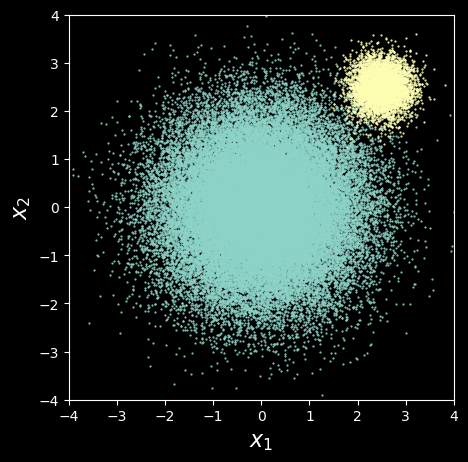

In [6]:
# Simple scatter plot of the first two dimensions of our data, background is in blue, signal is in orange
plt.figure(figsize = (5, 5))
plt.scatter(bkg_events_test[:, 0], bkg_events_test[:, 1], s=0.3, color='C0')
plt.scatter(sig_events_test[:, 0], sig_events_test[:, 1], s=0.3, color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.show()

In [7]:
# AE model

# Pick size of compressed representation (latent)
latent_size = 4
layers = [n_dim, 32, 16, latent_size, 16, 32, n_dim]

ae_model = Autoencoder(n_inputs=n_dim, 
                       layers=layers, 
                       val_split=0.1,
                       early_stopping=True, 
                       epochs=100, verbose=True)
ae_model.fit(bkg_events_train)


Epoch: 0


Train loss: 0.760676: 100%|██████████| 100000/100000 [00:05<00:00, 19102.33it/s]


Validation loss: 0.6853007543117494

Epoch: 1


Train loss: 0.669767: 100%|██████████| 100000/100000 [00:01<00:00, 54033.72it/s]


Validation loss: 0.6517779132746675

Epoch: 2


Train loss: 0.637063: 100%|██████████| 100000/100000 [00:01<00:00, 52644.55it/s]


Validation loss: 0.6211232526223068

Epoch: 3


Train loss: 0.609221: 100%|██████████| 100000/100000 [00:01<00:00, 53843.60it/s]


Validation loss: 0.5967413266677686

Epoch: 4


Train loss: 0.590363: 100%|██████████| 100000/100000 [00:01<00:00, 54765.08it/s]


Validation loss: 0.5827885390928639

Epoch: 5


Train loss: 0.577372: 100%|██████████| 100000/100000 [00:01<00:00, 51464.39it/s]


Validation loss: 0.5712562566218169

Epoch: 6


Train loss: 0.567880: 100%|██████████| 100000/100000 [00:01<00:00, 54352.74it/s]


Validation loss: 0.564542271177787

Epoch: 7


Train loss: 0.561623: 100%|██████████| 100000/100000 [00:01<00:00, 53282.63it/s]


Validation loss: 0.5606941115444578

Epoch: 8


Train loss: 0.557802: 100%|██████████| 100000/100000 [00:01<00:00, 54004.68it/s]


Validation loss: 0.5569641349260764

Epoch: 9


Train loss: 0.555011: 100%|██████████| 100000/100000 [00:01<00:00, 54717.85it/s]


Validation loss: 0.5556427026953539

Epoch: 10


Train loss: 0.553598: 100%|██████████| 100000/100000 [00:01<00:00, 51049.93it/s]


Validation loss: 0.5545333136073158

Epoch: 11


Train loss: 0.551653: 100%|██████████| 100000/100000 [00:01<00:00, 54880.30it/s]


Validation loss: 0.5511212263951826

Epoch: 12


Train loss: 0.551180: 100%|██████████| 100000/100000 [00:01<00:00, 54211.13it/s]


Validation loss: 0.550913350127847

Epoch: 13


Train loss: 0.550041: 100%|██████████| 100000/100000 [00:01<00:00, 53896.88it/s]


Validation loss: 0.5496911848597514

Epoch: 14


Train loss: 0.548584: 100%|██████████| 100000/100000 [00:01<00:00, 53061.27it/s]


Validation loss: 0.5480217501864104

Epoch: 15


Train loss: 0.548532: 100%|██████████| 100000/100000 [00:02<00:00, 49238.08it/s]


Validation loss: 0.5502958861001007

Epoch: 16


Train loss: 0.547921: 100%|██████████| 100000/100000 [00:01<00:00, 51725.69it/s]


Validation loss: 0.548006789344351

Epoch: 17


Train loss: 0.547511: 100%|██████████| 100000/100000 [00:01<00:00, 54811.38it/s]


Validation loss: 0.5464866309214735

Epoch: 18


Train loss: 0.546940: 100%|██████████| 100000/100000 [00:01<00:00, 51151.27it/s]


Validation loss: 0.5477196641666505

Epoch: 19


Train loss: 0.546026: 100%|██████████| 100000/100000 [00:01<00:00, 50363.52it/s]


Validation loss: 0.5444131242420972

Epoch: 20


Train loss: 0.545712: 100%|██████████| 100000/100000 [00:01<00:00, 54398.72it/s]


Validation loss: 0.5444166670979746

Epoch: 21


Train loss: 0.545332: 100%|██████████| 100000/100000 [00:01<00:00, 53605.12it/s]


Validation loss: 0.5455188545043511

Epoch: 22


Train loss: 0.544640: 100%|██████████| 100000/100000 [00:01<00:00, 52334.88it/s]


Validation loss: 0.5429865533814711

Epoch: 23


Train loss: 0.544192: 100%|██████████| 100000/100000 [00:01<00:00, 52770.80it/s]


Validation loss: 0.5449585919947271

Epoch: 24


Train loss: 0.544950: 100%|██████████| 100000/100000 [00:01<00:00, 54161.56it/s]


Validation loss: 0.5439852333206046

Epoch: 25


Train loss: 0.544237: 100%|██████████| 100000/100000 [00:01<00:00, 54289.26it/s]


Validation loss: 0.5442621273076748

Epoch: 26


Train loss: 0.543471: 100%|██████████| 100000/100000 [00:01<00:00, 53835.06it/s]


Validation loss: 0.5429394418931068

Epoch: 27


Train loss: 0.543703: 100%|██████████| 100000/100000 [00:01<00:00, 54628.45it/s]


Validation loss: 0.5424291116883383

Epoch: 28


Train loss: 0.543471: 100%|██████████| 100000/100000 [00:01<00:00, 53847.65it/s]


Validation loss: 0.5463964464643117

Epoch: 29


Train loss: 0.543403: 100%|██████████| 100000/100000 [00:01<00:00, 52372.92it/s]


Validation loss: 0.5417062973656008

Epoch: 30


Train loss: 0.541899: 100%|██████████| 100000/100000 [00:01<00:00, 52151.42it/s]


Validation loss: 0.5432174828503747

Epoch: 31


Train loss: 0.542259: 100%|██████████| 100000/100000 [00:01<00:00, 53869.64it/s]


Validation loss: 0.5432595057636881

Epoch: 32


Train loss: 0.542212: 100%|██████████| 100000/100000 [00:01<00:00, 52994.17it/s]


Validation loss: 0.5417801918047468

Epoch: 33


Train loss: 0.541654: 100%|██████████| 100000/100000 [00:01<00:00, 52589.76it/s]


Validation loss: 0.5431637675942057

Epoch: 34


Train loss: 0.541858: 100%|██████████| 100000/100000 [00:01<00:00, 53257.99it/s]


Validation loss: 0.5429807718071487

Epoch: 35


Train loss: 0.541797: 100%|██████████| 100000/100000 [00:01<00:00, 52262.89it/s]


Validation loss: 0.5415471116905017

Epoch: 36


Train loss: 0.541818: 100%|██████████| 100000/100000 [00:01<00:00, 50481.37it/s]


Validation loss: 0.5414220622509641

Epoch: 37


Train loss: 0.541249: 100%|██████████| 100000/100000 [00:01<00:00, 50913.81it/s]


Validation loss: 0.5418814805996083

Epoch: 38


Train loss: 0.541605: 100%|██████████| 100000/100000 [00:01<00:00, 52683.97it/s]


Validation loss: 0.5404991270864711

Epoch: 39


Train loss: 0.541529: 100%|██████████| 100000/100000 [00:01<00:00, 52754.91it/s]


Validation loss: 0.5413563853639471

Epoch: 40


Train loss: 0.541285: 100%|██████████| 100000/100000 [00:01<00:00, 52749.52it/s]


Validation loss: 0.5415732581597155

Epoch: 41


Train loss: 0.540836: 100%|██████████| 100000/100000 [00:01<00:00, 54489.07it/s]


Validation loss: 0.5415536884380423

Epoch: 42


Train loss: 0.540827: 100%|██████████| 100000/100000 [00:01<00:00, 55282.22it/s]


Validation loss: 0.5411901654642256

Epoch: 43


Train loss: 0.540441: 100%|██████████| 100000/100000 [00:01<00:00, 53663.96it/s]


Validation loss: 0.5406975238905538

Epoch: 44


Train loss: 0.540223: 100%|██████████| 100000/100000 [00:01<00:00, 52326.89it/s]


Validation loss: 0.5394646388947811

Epoch: 45


Train loss: 0.539647: 100%|██████████| 100000/100000 [00:01<00:00, 54765.59it/s]


Validation loss: 0.5396941697506039

Epoch: 46


Train loss: 0.539484: 100%|██████████| 100000/100000 [00:01<00:00, 52162.91it/s]


Validation loss: 0.5398265026948031

Epoch: 47


Train loss: 0.539133: 100%|██████████| 100000/100000 [00:01<00:00, 53246.95it/s]


Validation loss: 0.5385347546823799

Epoch: 48


Train loss: 0.537952: 100%|██████████| 100000/100000 [00:01<00:00, 52894.87it/s]


Validation loss: 0.5367726483537109

Epoch: 49


Train loss: 0.537234: 100%|██████████| 100000/100000 [00:01<00:00, 53020.41it/s]


Validation loss: 0.5373112215181751

Epoch: 50


Train loss: 0.534906: 100%|██████████| 100000/100000 [00:02<00:00, 49801.37it/s]


Validation loss: 0.5336625993328021

Epoch: 51


Train loss: 0.532944: 100%|██████████| 100000/100000 [00:01<00:00, 54110.78it/s]


Validation loss: 0.5305956566272794

Epoch: 52


Train loss: 0.530949: 100%|██████████| 100000/100000 [00:01<00:00, 52328.25it/s]


Validation loss: 0.5309949489429479

Epoch: 53


Train loss: 0.529627: 100%|██████████| 100000/100000 [00:01<00:00, 51990.28it/s]


Validation loss: 0.5268797975443208

Epoch: 54


Train loss: 0.525579: 100%|██████████| 100000/100000 [00:01<00:00, 50546.60it/s]


Validation loss: 0.5278499714858697

Epoch: 55


Train loss: 0.522515: 100%|██████████| 100000/100000 [00:01<00:00, 53334.80it/s]


Validation loss: 0.523322530300416

Epoch: 56


Train loss: 0.521233: 100%|██████████| 100000/100000 [00:01<00:00, 52848.63it/s]


Validation loss: 0.5203323479732285

Epoch: 57


Train loss: 0.519162: 100%|██████████| 100000/100000 [00:01<00:00, 53852.01it/s]


Validation loss: 0.5173460906347656

Epoch: 58


Train loss: 0.517687: 100%|██████████| 100000/100000 [00:02<00:00, 49561.08it/s]


Validation loss: 0.5146725271897548

Epoch: 59


Train loss: 0.514914: 100%|██████████| 100000/100000 [00:01<00:00, 53093.05it/s]


Validation loss: 0.5138727646425861

Epoch: 60


Train loss: 0.513918: 100%|██████████| 100000/100000 [00:01<00:00, 55971.85it/s]


Validation loss: 0.5122971924979364

Epoch: 61


Train loss: 0.513496: 100%|██████████| 100000/100000 [00:01<00:00, 52149.04it/s]


Validation loss: 0.5140256720506932

Epoch: 62


Train loss: 0.513821: 100%|██████████| 100000/100000 [00:02<00:00, 48812.05it/s]


Validation loss: 0.5139298912737985

Epoch: 63


Train loss: 0.513945: 100%|██████████| 100000/100000 [00:01<00:00, 52582.44it/s]


Validation loss: 0.5136756109230963

Epoch: 64


Train loss: 0.511988: 100%|██████████| 100000/100000 [00:01<00:00, 53971.04it/s]


Validation loss: 0.5100882763752852

Epoch: 65


Train loss: 0.511940: 100%|██████████| 100000/100000 [00:01<00:00, 54002.99it/s]


Validation loss: 0.5140404645972849

Epoch: 66


Train loss: 0.511695: 100%|██████████| 100000/100000 [00:01<00:00, 52823.75it/s]


Validation loss: 0.508161905743277

Epoch: 67


Train loss: 0.509073: 100%|██████████| 100000/100000 [00:01<00:00, 55712.41it/s]


Validation loss: 0.5065233667030968

Epoch: 68


Train loss: 0.506667: 100%|██████████| 100000/100000 [00:01<00:00, 52240.63it/s]


Validation loss: 0.5072681822663988

Epoch: 69


Train loss: 0.503865: 100%|██████████| 100000/100000 [00:01<00:00, 53551.66it/s]


Validation loss: 0.5166865192410891

Epoch: 70


Train loss: 0.501089: 100%|██████████| 100000/100000 [00:01<00:00, 51020.67it/s]


Validation loss: 0.49539569405186207

Epoch: 71


Train loss: 0.491777: 100%|██████████| 100000/100000 [00:01<00:00, 52825.23it/s]


Validation loss: 0.4800349912603798

Epoch: 72


Train loss: 0.475945: 100%|██████████| 100000/100000 [00:01<00:00, 53286.95it/s]


Validation loss: 0.4734934326023092

Epoch: 73


Train loss: 0.472465: 100%|██████████| 100000/100000 [00:01<00:00, 53685.68it/s]


Validation loss: 0.47920523313305263

Epoch: 74


Train loss: 0.474120: 100%|██████████| 100000/100000 [00:01<00:00, 54041.25it/s]


Validation loss: 0.4715680350809146

Epoch: 75


Train loss: 0.472298: 100%|██████████| 100000/100000 [00:01<00:00, 50912.18it/s]


Validation loss: 0.47197826000888027

Epoch: 76


Train loss: 0.469107: 100%|██████████| 100000/100000 [00:01<00:00, 54002.85it/s]


Validation loss: 0.46813247072727177

Epoch: 77


Train loss: 0.469654: 100%|██████████| 100000/100000 [00:01<00:00, 53961.06it/s]


Validation loss: 0.4691217966244349

Epoch: 78


Train loss: 0.470029: 100%|██████████| 100000/100000 [00:01<00:00, 51097.10it/s]


Validation loss: 0.4716191660336521

Epoch: 79


Train loss: 0.468704: 100%|██████████| 100000/100000 [00:01<00:00, 51880.28it/s]


Validation loss: 0.46795893024148233

Epoch: 80


Train loss: 0.467527: 100%|██████████| 100000/100000 [00:01<00:00, 50494.82it/s]


Validation loss: 0.4671556002953473

Epoch: 81


Train loss: 0.466985: 100%|██████████| 100000/100000 [00:01<00:00, 55105.13it/s]


Validation loss: 0.4658562773862458

Epoch: 82


Train loss: 0.466787: 100%|██████████| 100000/100000 [00:01<00:00, 53351.34it/s]


Validation loss: 0.46629159975692136

Epoch: 83


Train loss: 0.467912: 100%|██████████| 100000/100000 [00:01<00:00, 53414.88it/s]


Validation loss: 0.46355798592805253

Epoch: 84


Train loss: 0.463044: 100%|██████████| 100000/100000 [00:01<00:00, 54396.60it/s]


Validation loss: 0.46318156022549895

Epoch: 85


Train loss: 0.462057: 100%|██████████| 100000/100000 [00:01<00:00, 53921.04it/s]


Validation loss: 0.45983271034019985

Epoch: 86


Train loss: 0.462058: 100%|██████████| 100000/100000 [00:01<00:00, 51582.11it/s]


Validation loss: 0.46282309335668376

Epoch: 87


Train loss: 0.462144: 100%|██████████| 100000/100000 [00:01<00:00, 50203.52it/s]


Validation loss: 0.461932707549361

Epoch: 88


Train loss: 0.462017: 100%|██████████| 100000/100000 [00:02<00:00, 49371.01it/s]


Validation loss: 0.461710678799378

Epoch: 89


Train loss: 0.460860: 100%|██████████| 100000/100000 [00:01<00:00, 53870.89it/s]


Validation loss: 0.46137682971594585

Epoch: 90


Train loss: 0.458271: 100%|██████████| 100000/100000 [00:01<00:00, 51206.49it/s]


Validation loss: 0.45383481006793047

Epoch: 91


Train loss: 0.454576: 100%|██████████| 100000/100000 [00:01<00:00, 52263.34it/s]


Validation loss: 0.45366581432197406

Epoch: 92


Train loss: 0.450311: 100%|██████████| 100000/100000 [00:02<00:00, 49462.97it/s]


Validation loss: 0.4487882294999364

Epoch: 93


Train loss: 0.448553: 100%|██████████| 100000/100000 [00:01<00:00, 53864.08it/s]


Validation loss: 0.4459368071287794

Epoch: 94


Train loss: 0.445493: 100%|██████████| 100000/100000 [00:01<00:00, 53119.73it/s]


Validation loss: 0.4428018384501147

Epoch: 95


Train loss: 0.445150: 100%|██████████| 100000/100000 [00:01<00:00, 54999.37it/s]


Validation loss: 0.445353388100329

Epoch: 96


Train loss: 0.441358: 100%|██████████| 100000/100000 [00:01<00:00, 53916.26it/s]


Validation loss: 0.44071304367478853

Epoch: 97


Train loss: 0.440115: 100%|██████████| 100000/100000 [00:01<00:00, 53074.31it/s]


Validation loss: 0.4382016218226889

Epoch: 98


Train loss: 0.437859: 100%|██████████| 100000/100000 [00:01<00:00, 53485.60it/s]


Validation loss: 0.43579678748117384

Epoch: 99


Train loss: 0.435673: 100%|██████████| 100000/100000 [00:01<00:00, 53998.29it/s]


Validation loss: 0.43693817161080784


Autoencoder(early_stopping=True, layers=[10, 32, 16, 4, 16, 32, 10],
            n_inputs=10, val_split=0.1, verbose=True)

To see how well our autoencoder does as a classifier, we need to evaluate it on example signal and background events.
An autoencoder is not naturally a classifier, so in this case we use the mean squared error (input - output)^2 as an 'anomaly score' for each event.

Though it is not directly a classification probability as one would get from a classifier, it has similar properties (higher values means more signal-like), 
so we can directly use it for metrics like ROC curves and AUCs

In [8]:
# Do a quick check of the performance of the autoencoder as a classifier 

# predict_proba method of the Autoencoder computes MSE loss which we use as 'anomaly score' for each event 
y_test_ae = ae_model.predict_proba(x_test)
auc_ae = roc_auc_score(y_test, y_test_ae)

print(f"AE AUC {auc_ae:.3f}")

AE AUC 0.949


In order to gauge how well our autoencoder is doing we can compare it to serval benchmarks.

First we can see how well evaluating the true background pdf would do. We expect this to to similar to a well performing autoencder
We also train a supervised classifier and compute the likelihood ratio. We expect these to be sgnificantly better than the outlier detection methods

In [9]:
# Do a quick check of the performance of the true bkg pdf as a classifier 
#First evaluate P_bkg(x) using our PDF
x_test_bkg_pdf = bkg_pdf.pdf(x_test)

# One over bkg probability as outlier score 
y_test_pdf = 1./x_test_bkg_pdf

auc_pdf = roc_auc_score(y_test, y_test_pdf)
print(f"bkg PDF AUC {auc_pdf:.3f}")

bkg PDF AUC 0.953


In [10]:
# Use exact likelihood ratio to get optimal performance likelihood ratio
x_test_sig_pdf = sig_pdf.pdf(x_test)
likelihood_ratio = x_test_sig_pdf / x_test_bkg_pdf

auc_ratio = roc_auc_score(y_test, likelihood_ratio)
print(f"likelihood ratio AUC {auc_ratio:.3f}")

likelihood ratio AUC 1.000


In [11]:
# Train a supervised model for comparison

sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                    early_stopping=True, epochs=50,
                                    verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.185489: 100%|██████████| 16000/16000 [00:00<00:00, 39009.00it/s]


Validation loss: 0.03046378072758671

Epoch: 1


Train loss: 0.025749: 100%|██████████| 16000/16000 [00:00<00:00, 55752.98it/s]


Validation loss: 0.018102852001902647

Epoch: 2


Train loss: 0.019034: 100%|██████████| 16000/16000 [00:00<00:00, 51256.98it/s]


Validation loss: 0.01359211382077774

Epoch: 3


Train loss: 0.015128: 100%|██████████| 16000/16000 [00:00<00:00, 54373.19it/s]


Validation loss: 0.01025409880458028

Epoch: 4


Train loss: 0.013831: 100%|██████████| 16000/16000 [00:00<00:00, 51940.20it/s]


Validation loss: 0.009446980140637606

Epoch: 5


Train loss: 0.010895: 100%|██████████| 16000/16000 [00:00<00:00, 55785.10it/s]


Validation loss: 0.007222338817882701

Epoch: 6


Train loss: 0.010351: 100%|██████████| 16000/16000 [00:00<00:00, 56631.09it/s]


Validation loss: 0.00838613006635569

Epoch: 7


Train loss: 0.008654: 100%|██████████| 16000/16000 [00:00<00:00, 56154.00it/s]


Validation loss: 0.006163619255858066

Epoch: 8


Train loss: 0.008484: 100%|██████████| 16000/16000 [00:00<00:00, 54991.85it/s]


Validation loss: 0.010812775134581898

Epoch: 9


Train loss: 0.008766: 100%|██████████| 16000/16000 [00:00<00:00, 56570.99it/s]


Validation loss: 0.007094381429851637

Epoch: 10


Train loss: 0.008124: 100%|██████████| 16000/16000 [00:00<00:00, 56924.02it/s]


Validation loss: 0.005364099152757262

Epoch: 11


Train loss: 0.008272: 100%|██████████| 16000/16000 [00:00<00:00, 55589.50it/s]


Validation loss: 0.005867575123374991

Epoch: 12


Train loss: 0.007183: 100%|██████████| 16000/16000 [00:00<00:00, 56159.78it/s]


Validation loss: 0.0059333496838007704

Epoch: 13


Train loss: 0.006630: 100%|██████████| 16000/16000 [00:00<00:00, 52874.93it/s]


Validation loss: 0.005926147653099179

Epoch: 14


Train loss: 0.005792: 100%|██████████| 16000/16000 [00:00<00:00, 55899.60it/s]


Validation loss: 0.00889281120726082

Epoch: 15


Train loss: 0.006885: 100%|██████████| 16000/16000 [00:00<00:00, 56227.21it/s]


Validation loss: 0.006453914213125245

Epoch: 16


Train loss: 0.007531: 100%|██████████| 16000/16000 [00:00<00:00, 56134.46it/s]


Validation loss: 0.00593749118525011

Epoch: 17


Train loss: 0.005381: 100%|██████████| 16000/16000 [00:00<00:00, 56630.71it/s]


Validation loss: 0.005219079887410771

Epoch: 18


Train loss: 0.004853: 100%|██████████| 16000/16000 [00:00<00:00, 55262.83it/s]


Validation loss: 0.0067535137523009325

Epoch: 19


Train loss: 0.006574: 100%|██████████| 16000/16000 [00:00<00:00, 56275.12it/s]


Validation loss: 0.00625574408149987

Epoch: 20


Train loss: 0.005035: 100%|██████████| 16000/16000 [00:00<00:00, 55766.70it/s]


Validation loss: 0.006924030049049179

Epoch: 21


Train loss: 0.004320: 100%|██████████| 16000/16000 [00:00<00:00, 57007.63it/s]


Validation loss: 0.008660638595756609

Epoch: 22


Train loss: 0.004435: 100%|██████████| 16000/16000 [00:00<00:00, 56083.10it/s]


Validation loss: 0.007871960702232172

Epoch: 23


Train loss: 0.004599: 100%|██████████| 16000/16000 [00:00<00:00, 56859.39it/s]


Validation loss: 0.00640972982682797

Epoch: 24


Train loss: 0.004194: 100%|██████████| 16000/16000 [00:00<00:00, 56159.27it/s]


Validation loss: 0.007619170838438549

Epoch: 25


Train loss: 0.003707: 100%|██████████| 16000/16000 [00:00<00:00, 56456.34it/s]


Validation loss: 0.017773595301605383

Epoch: 26


Train loss: 0.005669: 100%|██████████| 16000/16000 [00:00<00:00, 56420.89it/s]


Validation loss: 0.00660888920015168

Epoch: 27


Train loss: 0.005013: 100%|██████████| 16000/16000 [00:00<00:00, 57526.65it/s]


Validation loss: 0.01115958714945009
Early stopping at epoch 27


NeuralNetworkClassifier(early_stopping=True, epochs=50, n_inputs=10,
                        verbose=True)

In [12]:
# Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print(f"Supervised AUC {auc_sup:.3f}")

Supervised AUC 1.000


/global/u1/t/train233/2024-lbnl/anomaly_tutorial/sk_cathode/utils/evaluation_functions.py:93: RuntimeWarning: divide by zero encountered in divide
  random_bkg_rej = 1 / random_fpr
/global/u1/t/train233/2024-lbnl/anomaly_tutorial/sk_cathode/utils/evaluation_functions.py:94: RuntimeWarning: invalid value encountered in divide
  random_sic = random_tpr / np.sqrt(random_tpr)


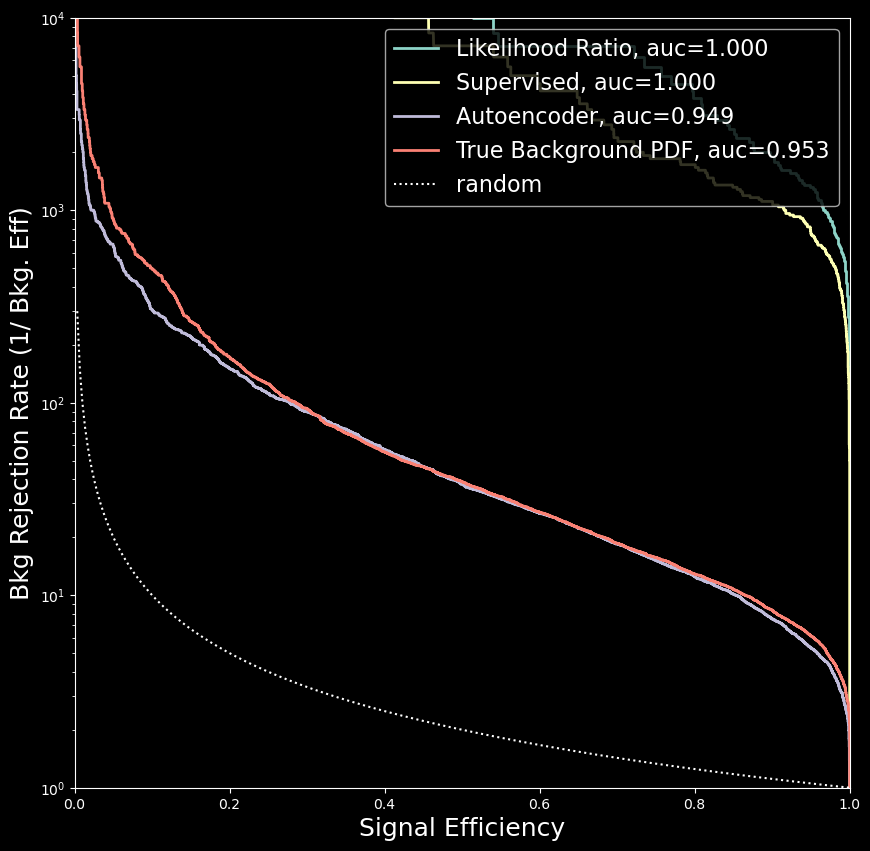

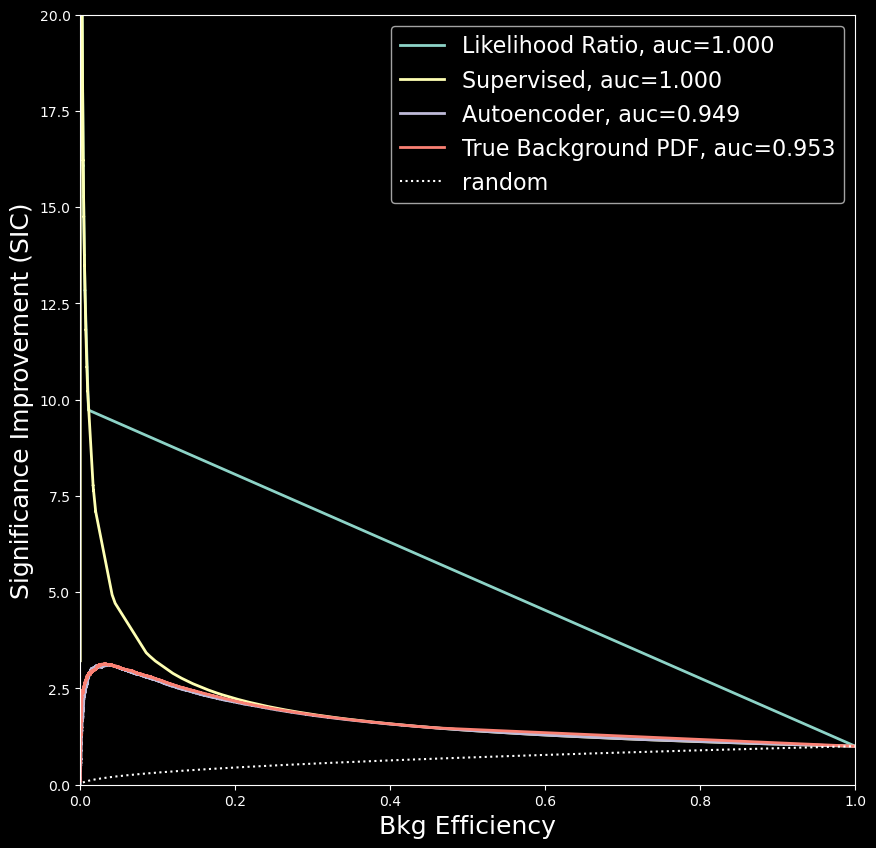

In [15]:
plot_roc_and_sic(y_test,
                 [likelihood_ratio, y_test_sup, y_test_ae, y_test_pdf],
                 labels = ['Likelihood Ratio', 'Supervised', 'Autoencoder',  'True Background PDF'], sic_max = 20)
plt.show()

We can see that the outlier detection methods, either based on the true background PDF or the autoencoder fall below the sensitivity of a supervised classifier. 
However they both are able to successfully enhance the sensitivity to the signal, by factors greater than ~2. 
The autoencoder performance is decently close to the true background PDF, which is encouraging. 

Feel free to now play around with how the results change if you change the latent size of the autoencoder, or change the signal or background PDF's.
Perhaps you can also compare the autoencoder performance to that of weak supervision on the same dataset. 